In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import sys
sys.path.append('../python')
import dataPython as dp
import scipy.interpolate as inter

from datetime import datetime
import scipy.integrate as si
import noordermeer as noord
import NGC5533_functions_newmag as nf
import time

If you do, DISCARD ALL CHANGES TO THE FILE.
Your calculations will NOT be consistent with this library's equations if you use the disk.hdf5 or bulge.hdf5 files,
and if you write to that file it will contain calculations based on conflicting constants.
Worst case scenario, reset the disk.hdf5 file to before the commit where you used this library to write to it.


In [ ]:
'''
SEPARATING SPARC DECOMP INTO JUST DISK AND JUST BULGE... FOR GIPYSY...
note that for some reason the files must be saved in the testing folder, otherwise I can't push the files to Kitty...
'''
decomp = dp.getXYZdata('NGC7814_decomp.dens')
r_decomp = decomp['xx'] #units kpc
d_decomp = decomp['yy'] #Lsun/pc**2 (i.e. Msun/pc**2 w/o the M-L ratio)
b_decomp = decomp['zz'] #Lsun/pc**2 

#gipsy doesn't like any values >=0, so remove first element... is there a better way to do this???
del r_decomp[0]
del d_decomp[0]
del b_decomp[0]
#notes: gipsy don't like more than 3 decimals. gipsy also don't like values of zero!!! (i.e the first point in the data file)


#save disk density file:
dfile = np.array([r_decomp, d_decomp])
dfile = dfile.T
np.savetxt('../testing/7814diskdecomp.rcl', dfile, delimiter = '	 ',fmt='%.3f')

#save bulge density file:
bfile = np.array([r_decomp, b_decomp])
bfile = bfile.T
np.savetxt('../testing/7814bulgedecomp.rcl', bfile, delimiter = '	 ',fmt='%.3f')



#remove last empty line from each text file bc gipsy don't like that either....
filename = '../testing/7814diskdecomp.rcl'

with open(filename) as f_input:
    data = f_input.read().rstrip('\n')

with open(filename, 'w') as f_output:    
    f_output.write(data)
    
filename = '../testing/7814bulgedecomp.rcl'

with open(filename) as f_input:
    data = f_input.read().rstrip('\n')

with open(filename, 'w') as f_output:    
    f_output.write(data)

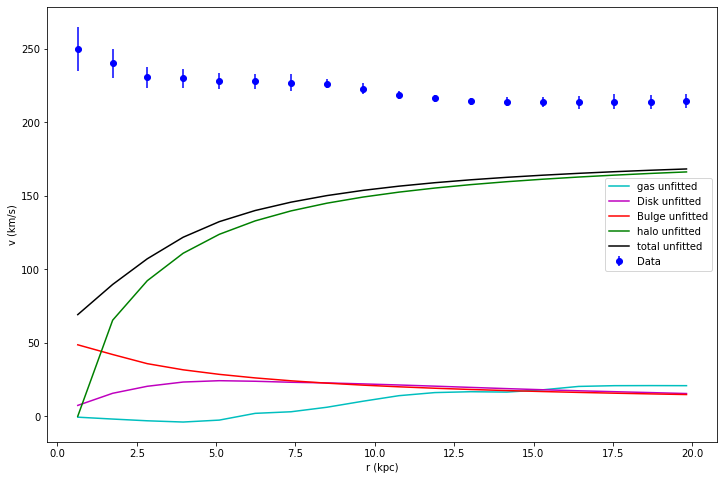

In [2]:
'''
source [1]: 
https://www.aanda.org/articles/aa/pdf/2011/07/aa16634-11.pdf
run in gipsy
Zlaw = sech-squared ???
Z0=.88 kpc (paper table 4 gives hz=.44kpc where z0=2*hz)
D=14.6 Mpc (paper table 1)
density profile Y
UNITS=kpc,mag/arcsec**2
RADDENS=<NGC7814disk4  <-- note that gipsy doesn't like scientific notation, i.e. 1.534e2 should be 153.4
MASS=1 ???? (stellar mass....)
RADII=0,0.64,1.74,2.83,3.96,5.10,6.23,7.36,8.49,9.63,10.76,11.89,13.02,14.16,15.29,16.42,17.55,18.69,19.82
(same points as raw data, table 3)
'''
#********************automatically replacing '!' with '#' so python doesn't throw hissy fit
import fileinput

with fileinput.FileInput('../testing/7814reallybulge.dat', inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace('!','#'), end='')
        
with fileinput.FileInput('../testing/7814reallydisk.dat', inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace('!','#'), end='')
        

#**********************importing text files******************************
#there's no need to import the radius for each component as everything has the same r array (the r array of the raw data)
#data:
data = dp.getXYdata_wXYerr('ngc7814data')
r = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err1 = np.asarray(data['ey'])
#disk:
disk = dp.getXYZdata('../testing/7814reallydisk.dat')
d = np.asarray(disk['zz'])
#bulge:
bulge = dp.getXYZdata('../testing/7814reallybulge.dat')
b = np.asarray(bulge['zz'])
#gas:
gas = dp.getXYZdata('../testing/7814gascomp.dat')
g = np.asarray(gas['zz'])

#***************************define total curve
#D=9.25 #disk M-L ratio provided in [1] 
#B=.5 #bulge M-L ratio provided in [1] 

def t(r,B,D,rc,rho00,G):
    return np.sqrt((D*d)**2
                   +(B*b)**2
                   +(nf.h_v(r,rc,rho00))**2
                   +(G*b)**2)
plt.figure(figsize=(12,8))

plt.plot(r,g,'c',label='gas unfitted')
'''
GIPSY input for gas component:
disk
Zlaw = sech-squared
Z0=.88
UNITS=kpc,msun/pc**2
RADDENS=<7814gas (unfortunately I had to datathief this...)
MASS=1.1 (according to total H1 mass in [1])
RADII=0.64,1.74,2.83,3.96,5.10,6.23,7.36,8.49,9.63,10.76,11.89,13.02,14.16,15.29,16.42,17.55,18.69,19.82
'''

plt.plot(r,d,'m',label='Disk unfitted')
'''
GIPSY input for disk:
disk
Zlaw = sech-squared
Z0=.88
UNITS=kpc,msun/pc**2
RADDENS=<7814diskdecomp4
MASS=1
RADII=0.64,1.74,2.83,3.96,5.10,6.23,7.36,8.49,9.63,10.76,11.89,13.02,14.16,15.29,16.42,17.55,18.69,19.82
'''
plt.plot(r,b,'r',label='Bulge unfitted') 
'''
GIPSY input for bulge:
bulge
UNITS=kpc,msun/pc**2
RADDENS=<7814bulgedecomp3 
MASS=1
RADII=0.64,1.74,2.83,3.96,5.10,6.23,7.36,8.49,9.63,10.76,11.89,13.02,14.16,15.29,16.42,17.55,18.69,19.82
'''
rc=2.5 #default value
rho00=1e8 #default value
plt.plot(r,nf.h_v(r,rc,rho00),'g',label='halo unfitted')
plt.plot(r,t(r,1,1,rc,rho00,1),'k',label='total unfitted')
plt.errorbar(r,v_dat,yerr=v_err1,fmt='bo',label='Data')

plt.xlabel('r (kpc)')
plt.ylabel('v (km/s)')
plt.legend()
plt.show()

In [3]:
v_err1=v_err1
weighdata=1/v_err1
# LMFit

#Setup
g_mod = lm.Model(t)
g_params = g_mod.make_params()

#gas
g_params.add('G', value=1, min=.99,max=1.01)          #Prefactor
#Bulge
g_params.add('B', value=1, min=0)          #Prefactor

#Disk
g_params.add('D', value=1, min=0)       #Prefactor
#Halo
g_params.add('rc', value=rc, min=0)          #Core radius (kpc)
g_params.add('rho00', value=rho00, min=0)     #Central density 

#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r,weights=weighdata)

In [4]:
# Define for plotting
bestg = g_fit.best_fit
#delg = g_fit.eval_uncertainty()
print('Fit information for all-component fit:')
g_fit

Fit information for all-component fit:


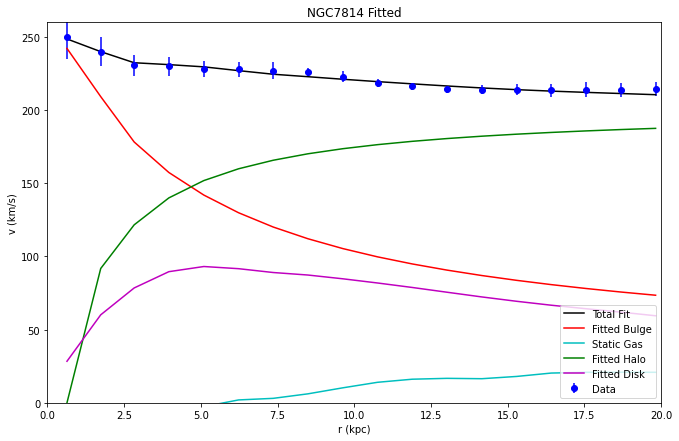

In [5]:
# Define for plotting cont.

#rval = np.linspace(0,11.2,0.1)

g_dict = g_fit.best_values
g_b = g_dict['B']
g_d = g_dict['D']
g_rc = g_dict['rc']
g_rho00 = g_dict['rho00']
g_g = g_dict['G']
halo_curve = nf.h_v(r,g_rc,g_rho00)

plt.figure(figsize=(11,7))
plt.errorbar(r,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r,bestg,'k',label='Total Fit')
plt.plot(r,g_b*b,'r',label='Fitted Bulge')
plt.plot(r,g_g*g,'c',label='Static Gas')
plt.plot(r,halo_curve,'g',label='Fitted Halo')
plt.plot(r,g_d*d,'m',label='Fitted Disk')

plt.legend(loc='lower right')
plt.xlabel('r (kpc)')
plt.ylabel('v (km/s)')
plt.title('NGC7814 Fitted')
plt.ylim([0,260])
plt.xlim([0,20])
plt.show()